In [1]:
# This is the initial take of pulling the MNIST CBIR from https://blog.sicara.com/keras-tutorial-content-based-image-retrieval-convolutional-denoising-autoencoder-dc91450cc511
#    and making it work in a Jupyter notebook for unrotated pill images.



In [14]:
import keras
keras.__version__

'2.2.2'

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2288064097808613422
]


In [16]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [40]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

## Train model

In [111]:
target_image_size = (64,112)
target_image_size_3D = (64,112,1)

In [112]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


# For training
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [113]:
def display_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        plt.imshow(single_image)
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        plt.imshow(si)
        
def get_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        return single_image
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        return si
    

In [114]:
# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        #shear_range=0.05,
        #zoom_range=0.01,
        #rotation_range=5.00,
        #height_shift_range=0.10,
        #width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        'data_with_rotations/train',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode='grayscale')

validation_generator = validation_datagen.flow_from_directory(
        'data_with_rotations/validate',
        target_size=target_image_size,
        batch_size=32,
        class_mode='input',
        color_mode='grayscale')



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


Found 96 images belonging to 1 classes.
1


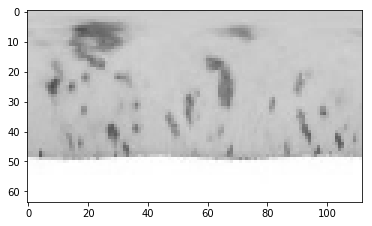

In [115]:
# Get 16 sample images to use throughout all the training for visualization
# Load Test images to generate testing data
sample_datagen = ImageDataGenerator(rescale=1. / 255)

sample_generator = sample_datagen.flow_from_directory(
        'data_with_rotations/test',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode='grayscale')

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]
ti = test_image

print(np.shape(ti)[-1])

display_image(test_image)

#test_display = np.concatenate((ti,ti,ti), axis=2)

#plt.imshow(test_display)

#plt.show()


In [116]:
len(test_image[:,:,0])
np.shape(sample_images)

(16, 64, 112, 1)

In [117]:
def define_model():
    
    big_conv = (7,7)
    num_conv = 128
    
    
    #Input
    input_img = Input(shape=target_image_size_3D, name='input')  # adapt this if using `channels_first` image data format
    
     # Layer 10
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
#    # Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
#    
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
     # Layer 30

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # Uplayer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 30
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)


#    #Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
#    
#    x = Conv2D(32, (3, 3), activation='relu')(x)
#    #x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
    
    # Uplayer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)


    autoencoder = Model(input_img, outputs=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    
    #autoencoder.fit_generator(
    #    train_generator,
    #    steps_per_epoch=2000,
    #    epochs=10,
    #    validation_data=validation_generator,
    #    validation_steps=800)
        #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])
    
    # autoencoder.save('autoencoder_pill.h5')



In [118]:
class ProgressCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #print('epoch ended')
        #print(self.model)
        
        processed_images = self.model.predict(x=sample_images,batch_size=16)
         
        
        # plot the image
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        sim = get_image(sample_images[0])
        plt.imshow(sim)
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        pim = get_image(processed_images[0])
        plt.imshow(pim)
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        plt.show()


In [119]:


def train_model(model_to_train):
    progress = ProgressCallback()
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=3,
        validation_data=validation_generator,
        validation_steps=50,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save('autoencoder_pill4.h5')
    
    return model_to_train

In [120]:
# Train the model
x = define_model()

[<tf.Tensor 'decoded_8/Sigmoid:0' shape=(?, 64, 112, 1) dtype=float32>]


In [121]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 112, 1)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 112, 16)       416       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 56, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 28, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 14, 32)         0         
__________

In [122]:
e = x.get_layer('encoder')
e.output

<tf.Tensor 'encoder_9/MaxPool:0' shape=(?, 4, 7, 128) dtype=float32>

In [123]:
progress = ProgressCallback()

In [124]:
autoencoder = train_model(x)

Epoch 1/3
200/200 [==============================] - 37s 183ms/step - loss: 0.5264 - val_loss: 0.5064
Epoch 2/3
200/200 [==============================] - 37s 183ms/step - loss: 0.5111 - val_loss: 0.4872
Epoch 3/3
200/200 [==============================] - 37s 183ms/step - loss: 0.5036 - val_loss: 0.4784


In [127]:
#!pip3 install jupyter-tensorboard
for i in range(5):
    autoencoder = train_model(x)

Epoch 1/3
200/200 [==============================] - 37s 184ms/step - loss: 0.4928 - val_loss: 0.4689
Epoch 2/3
200/200 [==============================] - 37s 184ms/step - loss: 0.4919 - val_loss: 0.4693
Epoch 3/3
200/200 [==============================] - 37s 186ms/step - loss: 0.4925 - val_loss: 0.4693
Epoch 1/3
200/200 [==============================] - 37s 186ms/step - loss: 0.4929 - val_loss: 0.4691
Epoch 2/3
200/200 [==============================] - 37s 187ms/step - loss: 0.4921 - val_loss: 0.4690
Epoch 3/3
200/200 [==============================] - 37s 187ms/step - loss: 0.4924 - val_loss: 0.4690
Epoch 1/3
200/200 [==============================] - 38s 188ms/step - loss: 0.4924 - val_loss: 0.4687
Epoch 2/3
200/200 [==============================] - 38s 188ms/step - loss: 0.4925 - val_loss: 0.4689
Epoch 3/3
200/200 [==============================] - 38s 188ms/step - loss: 0.4920 - val_loss: 0.4689
Epoch 1/3
200/200 [==============================] - 38s 188ms/step - loss: 0.4924

In [70]:
#!tensorboard --logdir=/tmp/tb
#autoencoder = train_model(x) #Results from only 16 convolutions vs 64

## Test the model

In [71]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



In [72]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model('autoencoder_pill4.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)

scores = []

Loading model :
Model loaded in:  1.2506449222564697


In [73]:
# Load Test images to generate testing data
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
        'data_with_rotations/test',
        target_size=(52, 100),
        batch_size=32,
        class_mode='input',
        color_mode='grayscale',
        shuffle=False)







Found 96 images belonging to 1 classes.


In [81]:
class all_directory_images_generator:
    def __init__(self, sourcedir='data_with_rotations/test', batch_size=16):
        self.batch_size = batch_size
        self.sourcedir = sourcedir
        
        self.test_datagen = ImageDataGenerator(rescale=1. / 255)
        self.test_generator = self.test_datagen.flow_from_directory(
                sourcedir,
                target_size=(64, 104),
                batch_size=self.batch_size,
                class_mode='input',
                color_mode='grayscale',
                shuffle=False)
        
        self.n = self.test_generator.n
        self.filenames = self.test_generator.filenames
        
        self.current_batch = 0
        self.max_batch = int(self.n / self.batch_size)
    def __iter__(self):
        return self

    def __next__(self):
        bi = self.test_generator.batch_index
        bs = self.test_generator.batch_size
        batch_file_names = test_generator.filenames[bi*bs:bi*bs+bs]
        return (next(self.test_generator), batch_file_names)



In [82]:
# Create a new model from the autoencoder, only up to the embedding layer
enc_model = Model(autoencoder.input, autoencoder.get_layer('encoder').output)

x = enc_model.get_layer('encoder').output
x = GlobalMaxPooling2D(name='flat')(x)
encoder = Model(enc_model.input, x)




In [83]:
dict = {}


test_images = all_directory_images_generator(batch_size=16)
bs = test_images.batch_size

for i in range(test_images.max_batch):
    images_both_x_and_y, names = next(test_images)
    images = images_both_x_and_y[0]
    encodings = encoder.predict(images,batch_size=bs)
    for j in range(bs):
        dict[names[j]]=encodings[j]
        


    
    

Found 96 images belonging to 1 classes.


In [84]:
import pandas as pd
df = pd.DataFrame.from_dict(dict, orient='index')
df
#HOLY COW!  All of these are so close together. :-(  Can't differentiate one from another easily - Deeper network help?


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
images/229.jpg,0.496661,0.000000,0.251785,0.195217,0.150866,0.304767,0.147517,0.544485,0.000000,0.659998,...,0.207590,0.078865,0.0,0.247946,0.089028,0.072869,0.355870,0.443773,0.067982,0.014180
images/229_196.jpg,0.497328,0.000000,0.252152,0.194253,0.157037,0.296049,0.144529,0.531880,0.020909,0.660125,...,0.220662,0.058119,0.0,0.244138,0.093018,0.078867,0.360045,0.454371,0.061211,0.021249
images/229_262.jpg,0.495792,0.000000,0.251806,0.186122,0.156408,0.319250,0.156957,0.534767,0.017225,0.659689,...,0.221302,0.058731,0.0,0.243754,0.092940,0.080227,0.358875,0.445329,0.059956,0.021553
images/229_45.jpg,0.429802,0.000000,0.252152,0.190757,0.164692,0.300444,0.152760,0.533478,0.030504,0.659752,...,0.207348,0.058234,0.0,0.241233,0.084946,0.082071,0.350620,0.446566,0.074074,0.020901
images/230.jpg,0.460041,0.000000,0.252743,0.208816,0.133159,0.221530,0.142751,0.535622,0.000143,0.660555,...,0.213944,0.058056,0.0,0.240431,0.090660,0.068222,0.322736,0.443380,0.063065,0.021826
images/230_200.jpg,0.455202,0.000000,0.253656,0.213023,0.133776,0.258399,0.144143,0.526869,0.000000,0.660512,...,0.209565,0.057904,0.0,0.230713,0.080474,0.060910,0.318814,0.440434,0.059340,0.021369
images/230_287.jpg,0.432939,0.000000,0.252295,0.210477,0.129649,0.212941,0.144653,0.528330,0.000000,0.660709,...,0.206892,0.057880,0.0,0.236675,0.080683,0.069066,0.319852,0.442751,0.057193,0.020312
images/230_341.jpg,0.458721,0.000000,0.252772,0.212014,0.133341,0.229134,0.143171,0.503722,0.000000,0.660679,...,0.214243,0.057818,0.0,0.239738,0.089774,0.059315,0.318660,0.442883,0.061372,0.022862
images/231.jpg,0.483512,0.000000,0.252864,0.216675,0.136352,0.327012,0.132105,0.500359,0.015462,0.660889,...,0.214297,0.057811,0.0,0.240911,0.090863,0.108599,0.334959,0.428264,0.061278,0.021582
images/231_212.jpg,0.481187,0.000000,0.253263,0.218428,0.138265,0.292120,0.133935,0.501224,0.000000,0.660936,...,0.205212,0.058153,0.0,0.236121,0.083234,0.103248,0.332314,0.427922,0.060717,0.020543


Found 96 images belonging to 1 classes.


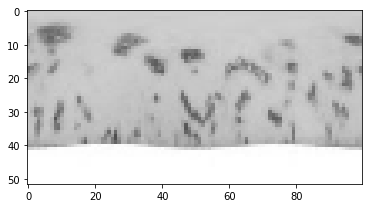

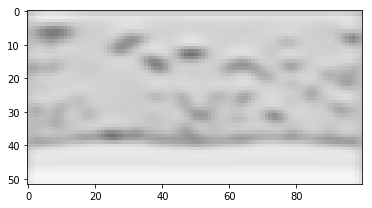

images/229.jpg


In [78]:
# Let's just view a few input images and output images

test_images=all_directory_images_generator()

next_batch, next_filenames = next(test_images)
#next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(get_image(recreated_pill[0]))
plt.show()
print(next_filenames[0])
#categories = next_batch[1]
#print(categories[0])

In [39]:
enc_model = Model(autoencoder.input, autoencoder.layers[2].output)


In [40]:
enc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 52, 100, 1)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 100, 64)       1664      
_________________________________________________________________
encoder (Conv2D)             (None, 52, 100, 16)       9232      
Total params: 10,896
Trainable params: 10,896
Non-trainable params: 0
_________________________________________________________________


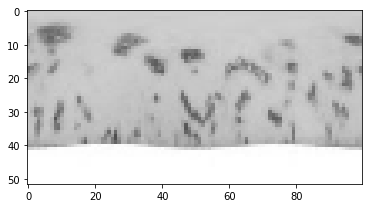

In [41]:
# See what our output looks like
# Let's just view a few input images and see results

next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

embeddings = enc_model.predict(x=images,batch_size=32)



In [42]:
#test_generator.filenames

In [43]:
embeddings.shape


(32, 52, 100, 16)

In [44]:
e = embeddings[0].flatten()
e

array([0.44578773, 0.6116289 , 0.4794868 , ..., 0.36802438, 0.33206958,
       0.4621178 ], dtype=float32)

In [45]:
enc_model.layers[-1].name

'encoder'

In [46]:

x = enc_model.get_layer('encoder').output
x = GlobalMaxPooling2D(name='flat')(x)
new_model = Model(enc_model.input, x)


#short_base = Model(base_model.get_layer('input_11').input, base_model.get_layer('avg_pool'))

Found 96 images belonging to 1 classes.


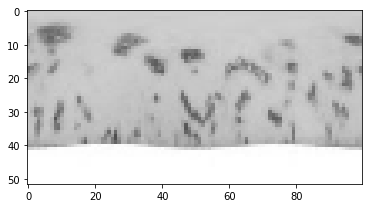

images/229.jpg


In [49]:
# See what our output looks like
# Let's just view a few input images and see results

mygen = all_directory_images_generator(batch_size=32)

next_images, next_filenames = next(mygen)
images = next_images[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

embeddings2 = new_model.predict(x=images,batch_size=32)

print(next_filenames[0])


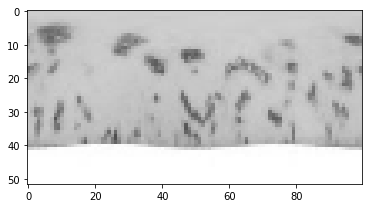

images/229.jpg


In [52]:
next_images, next_filenames = next(mygen)
images = next_images[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

embeddings2 = new_model.predict(x=images,batch_size=32)

print(next_filenames[0])

In [273]:
# For confusion matrix, you need two items, y_test and y_pred
#     y_test is the known categorical values of the test set 
#     y_pred is the predicted categorical values of the test set 

# To get y_test we'll use the validation_generator, but let's grab all images
#test_generator.batch_size = 751

nb_batches_to_capture = 1 # batches * batch_size should be less than total number of items available, else repeats will happen

y_true = []
y_pred = []

for index in range(nb_batches_to_capture):
    next_batch = next(test_generator)
    #images = next_batch[0]
    #print(images[0])
    categories = next_batch[1]
    #print(categories[0])
    #print(len(categories))
    # To get y_pred, we actually need to predict the categories of the all_images set
    #predicted_categories= model.predict_classes(x=images,batch_size=batch_size)
    #print(len(predicted_categories))
    #if len(categories) == len(predicted_categories):
    #    y_true.extend(categories)
    #    y_pred.extend(predicted_categories)
    #else:
    #    print("Mismatched actual and predicted - ignoring batch")
    
print(len(y_true))
print(len(y_pred))

0
0


In [191]:
# Create methods for determining closest image
def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    #cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))



In [192]:
# Create methods to test the model
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


In [193]:

# To test the whole model
n_test_samples = 100
#n_train_samples = [10, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,
#                   20000, 30000, 40000, 50000, 60000]

n_train_samples = [10]

for n_train_sample in n_train_samples:
    test_model(n_test_samples, n_train_sample)








NameError: name 'x_train' is not defined

In [ ]:
# Save model
np.save('computed_data/scores', np.array(scores))

In [ ]:
# To retrieve closest image
retrieve_closest_images(x_test[0], y_test[0])


In [ ]:

# To plot a denoised image
plot_denoised_images()

In [ ]:
print('hello')